# Supervised Contrastive Learning based supervised classification vs Softmax Classification
This notebook demonstrates the effectiveness of supervised contrastive learning compared to traditional softmax classification. We'll implement both approaches on the same dataset and compare their performance.

Key objectives:
1. Implement supervised contrastive loss
2. Compare with standard softmax cross-entropy loss
3. Visualize embeddings and performance metrics

## Import Required Libraries
We need TensorFlow for building the model, matplotlib for visualization, and TSNE for visualizing high-dimensional embeddings.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import keras
from keras import layers

## Data Preparation
Load CIFAR-10 dataset and normalize pixel values to [0,1] range. Apply data augmentation including random flips, rotations, and zoom to improve model generalization.

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


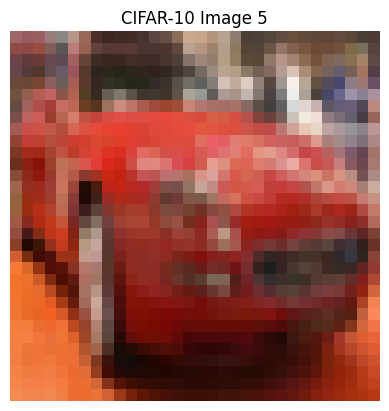

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train is loaded as in your provided code
# If x_train is not available in this context, replace this with a sample image:
# For Example:
# x_train = np.random.rand(32, 32, 3)  # Create a random image

# Reshape if needed, e.g., if x_train is a 4D array:
if len(x_train.shape) == 4:
    image_index = 5  # Choose an image to display
    image_to_display = x_train[image_index]

    # Display the image
    plt.imshow(image_to_display)
    plt.axis('off')  # Hide axes
    plt.title(f"CIFAR-10 Image {image_index}")
    plt.show()
elif len(x_train.shape) == 3:
    plt.imshow(x_train)
    plt.axis('off')
    plt.title("Image")
    plt.show()

else:
  print("x_train shape is not 3 or 4. Cannot display image.")


## Supervised Contrastive Loss Implementation
The contrastive loss pulls representations of samples with the same label closer together while pushing apart samples with different labels. Key components:
- Temperature scaling to control the sharpness of the distribution
- L2 normalization of projections
- Positive pair identification based on labels
- Negative log-likelihood computation for contrastive learning

In [5]:
# Supervised Contrastive Loss implementation
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def call(self, projections, labels):
        batch_size = tf.shape(projections)[0]

        # Normalize projections
        projections = tf.math.l2_normalize(projections, axis=1)

        # Compute similarity matrix
        logits = tf.matmul(projections, projections, transpose_b=True) / self.temperature

        # Mask for positive pairs (same label)
        labels = tf.cast(tf.reshape(labels, [-1, 1]), tf.float32)
        mask = tf.equal(labels, tf.transpose(labels))
        mask = tf.cast(mask, tf.float32)

        # Remove diagonal elements
        logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
        positive_mask = mask * logits_mask

        # Compute exp sum
        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

        # Compute mean for positives
        mean_log_prob_pos = tf.reduce_sum(positive_mask * log_prob, axis=1) / tf.reduce_sum(positive_mask, axis=1)
        loss = -mean_log_prob_pos
        loss = tf.reduce_mean(loss)

        return loss

## Model Architecture
We define the encoder (feature extractor) and projection head separately:
- Encoder: CNN architecture to extract meaningful features from images
- Projection head: Maps features to embedding space for contrastive learning
This separation allows us to use the encoder directly for downstream tasks after contrastive pretraining.

In [6]:
# Base encoder architecture
def create_encoder(input_shape=(32, 32, 3)):
    encoder = tf.keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu')
    ])
    return encoder

# Projection head for contrastive learning
def create_projection_head(input_dim=64, output_dim=128):
    projection_head = tf.keras.Sequential([
        layers.Dense(output_dim, activation='relu'),
        layers.Dense(output_dim)
    ])
    return projection_head

## Contrastive Learning Model
This model combines the encoder and projection head for contrastive learning. The train_step method:
1. Computes projections for input images
2. Calculates supervised contrastive loss
3. Updates model weights using gradients

In [7]:
# Contrastive learning model
class ContrastiveModel(tf.keras.Model):
    def __init__(self, encoder, projection_head):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.contrastive_loss = SupervisedContrastiveLoss()

    def call(self, inputs, training=None):
        features = self.encoder(inputs)
        projections = self.projection_head(features)
        return projections

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            projections = self(x, training=True)
            loss = self.contrastive_loss(projections, y)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'loss': loss}

# Create and compile models
encoder = create_encoder()
projection_head = create_projection_head()
contrastive_model = ContrastiveModel(encoder, projection_head)
contrastive_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training Contrastive Model
Since the custom ContrastiveModel handles its own loss computation, we implement a custom training loop. This allows us to train with the supervised contrastive loss. After training, we extract the encoder and add a classification head for downstream tasks.

In [8]:
# Train contrastive model
# Create a custom training loop for better control
batch_size = 256
epochs = 5
steps_per_epoch = x_train.shape[0] // batch_size

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0

    for step in range(steps_per_epoch):
        start_idx = step * batch_size
        end_idx = start_idx + batch_size

        batch_x = x_train[start_idx:end_idx]
        batch_y = y_train[start_idx:end_idx]

        loss = contrastive_model.train_step((batch_x, batch_y))['loss']
        total_loss += loss

        if (step + 1) % 50 == 0:
            print(f"Step {step+1}/{steps_per_epoch}: Loss = {loss:.4f}")

    avg_loss = total_loss / steps_per_epoch
    print(f"Average loss: {avg_loss:.4f}")

# Extract encoder for classification
pretrained_encoder = contrastive_model.encoder

# Add classifier head
classifier_contrastive = tf.keras.Sequential([
    pretrained_encoder,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

classifier_contrastive.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/5
Step 50/195: Loss = 5.2983
Step 100/195: Loss = 5.2475
Step 150/195: Loss = 5.1861
Average loss: 5.2452

Epoch 2/5
Step 50/195: Loss = 5.0714
Step 100/195: Loss = 5.0270
Step 150/195: Loss = 4.9836
Average loss: 5.0473

Epoch 3/5
Step 50/195: Loss = 4.9549
Step 100/195: Loss = 4.8475
Step 150/195: Loss = 4.9405
Average loss: 4.9494

Epoch 4/5
Step 50/195: Loss = 4.9075
Step 100/195: Loss = 4.7886
Step 150/195: Loss = 4.8679
Average loss: 4.8885

Epoch 5/5
Step 50/195: Loss = 4.8339
Step 100/195: Loss = 4.7388
Step 150/195: Loss = 4.8153
Average loss: 4.8306


## Training Softmax Baseline
Train a standard CNN classifier with softmax output from scratch for comparison. This model uses the same architecture as our encoder but is trained directly for classification without contrastive pretraining.

In [9]:
classifier_softmax = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classifier_softmax.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

softmax_history = classifier_softmax.fit(
    x_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2752 - loss: 1.9675 - val_accuracy: 0.4327 - val_loss: 1.5804
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4753 - loss: 1.4509 - val_accuracy: 0.5009 - val_loss: 1.3926
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5193 - loss: 1.3299 - val_accuracy: 0.5416 - val_loss: 1.2830
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5609 - loss: 1.2344 - val_accuracy: 0.5744 - val_loss: 1.2029
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5889 - loss: 1.1612 - val_accuracy: 0.5831 - val_loss: 1.2005


## Classifier Training and Evaluation
Train the classification head for the contrastive pretrained model. We then evaluate both models (softmax baseline and contrastive pretrained) on the test set to compare their performance. The contrastive pretrained model should achieve better accuracy due to the improved feature representations learned during pretraining.

In [ ]:
# Train classifier with contrastive pretrained encoder
print("\nTraining classifier with contrastive pretrained encoder...")
contrastive_classifier_history = classifier_contrastive.fit(
    x_train, y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Evaluate both models
softmax_score = classifier_softmax.evaluate(x_test, y_test, verbose=0)
contrastive_score = classifier_contrastive.evaluate(x_test, y_test, verbose=0)

print(f"\nSoftmax Model Test Accuracy: {softmax_score[1]:.4f}")
print(f"Contrastive Pretrained Model Test Accuracy: {contrastive_score[1]:.4f}")


Training classifier with contrastive pretrained encoder...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3165 - loss: 1.8390 - val_accuracy: 0.5722 - val_loss: 1.2051
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5559 - loss: 1.2222 - val_accuracy: 0.6047 - val_loss: 1.1002
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6062 - loss: 1.0936 - val_accuracy: 0.6398 - val_loss: 1.0303
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6396 - loss: 1.0176 - val_accuracy: 0.6597 - val_loss: 0.9757
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6638 - loss: 0.9619 - val_accuracy: 0.6644 - val_loss: 0.9539
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6840 - loss: 0.9046 - val_accuracy: 0.6807 - val_loss: 0.9049
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6980 - loss: 0.8665 - val_accuracy: 0.6894 - val_loss: 0.8812
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1

## Embedding Visualization
Extract embeddings from both models and apply t-SNE to reduce dimensionality to 2D for visualization. This helps us understand how well each model separates different classes in the feature space.

In [ ]:
# Simplest approach - use predict method to get embeddings
print("Getting embeddings using predict method...")

# For contrastive model - extract encoder features directly
contrastive_encoder = contrastive_model.encoder
contrastive_features = contrastive_encoder.predict(x_test[:2000], batch_size=256)

# For softmax model - create a feature extractor
softmax_feature_extractor = tf.keras.Sequential(classifier_softmax.layers[:-1])
softmax_features = softmax_feature_extractor.predict(x_test[:2000], batch_size=256)

# Apply t-SNE
print("Computing t-SNE for contrastive embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_contrastive_2d = tsne.fit_transform(contrastive_features)

print("Computing t-SNE for softmax embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_softmax_2d = tsne.fit_transform(softmax_features)

print("t-SNE completed!")

Getting embeddings using predict method...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Computing t-SNE for contrastive embeddings...
Computing t-SNE for softmax embeddings...
t-SNE completed!


## Visualization of Feature Embeddings
Create side-by-side t-SNE visualizations to compare how well both models separate different classes in the feature space. Contrastive learning typically produces more distinct clusters for each class compared to standard classification.

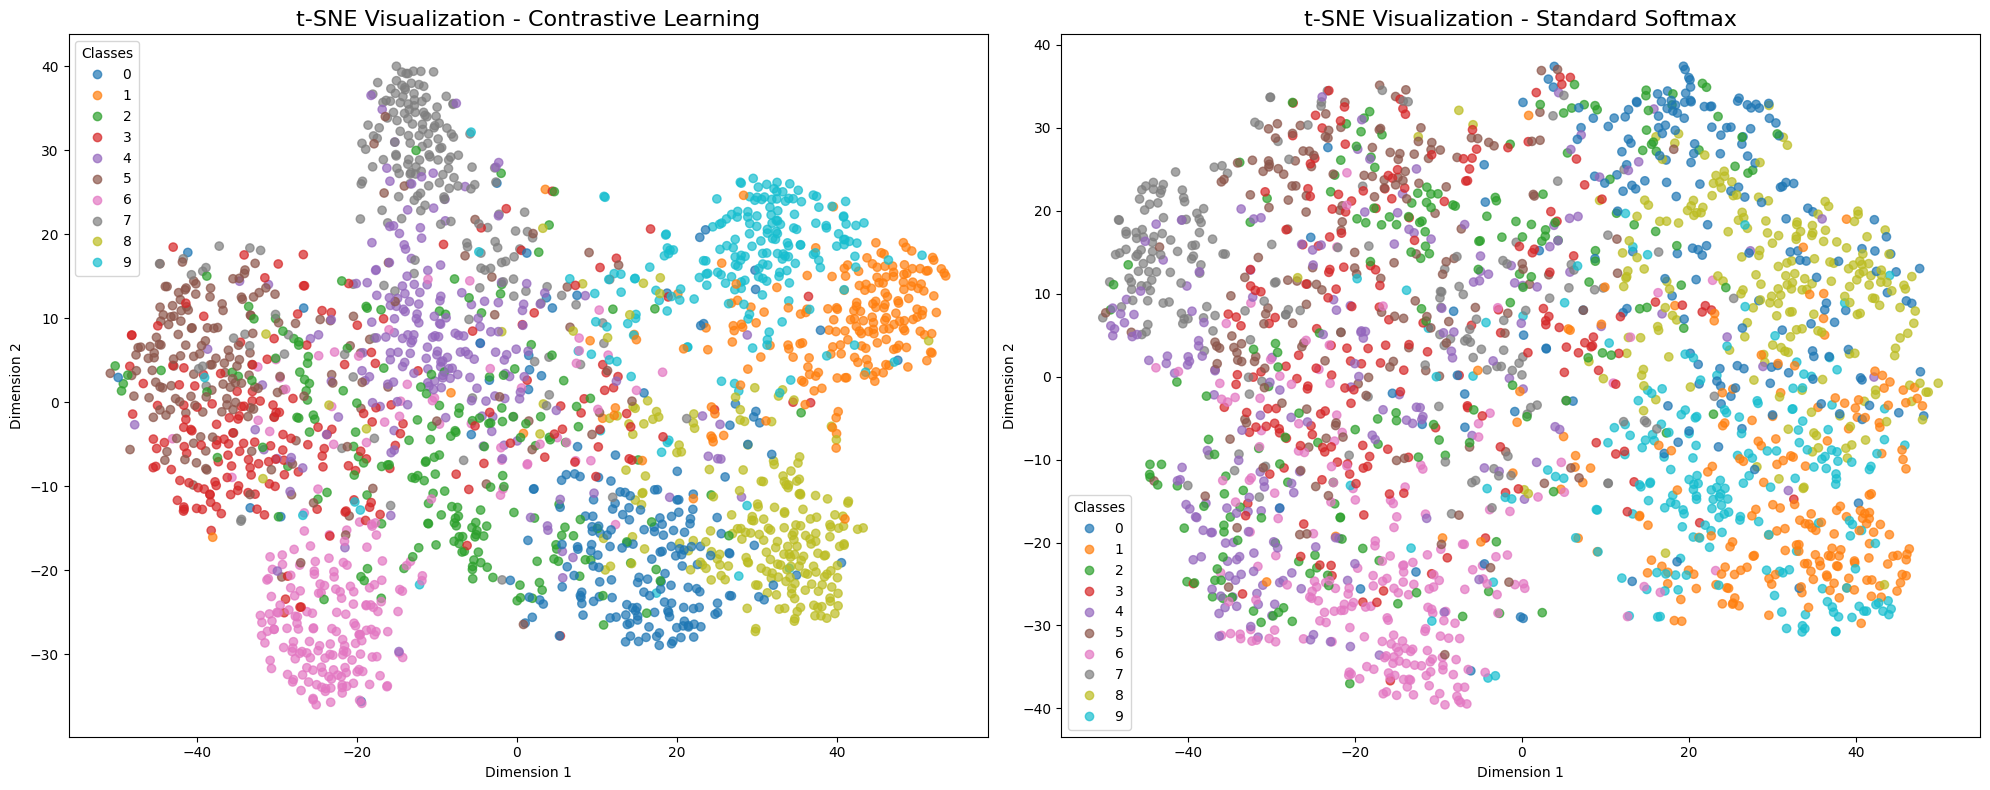

In [ ]:
# Plot t-SNE visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot contrastive embeddings
scatter1 = ax1.scatter(embeddings_contrastive_2d[:, 0], embeddings_contrastive_2d[:, 1],
                       c=y_test[:2000], cmap='tab10', alpha=0.7)
ax1.set_title("t-SNE Visualization - Contrastive Learning", fontsize=16)
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.legend(*scatter1.legend_elements(), title="Classes", loc="best")

# Plot softmax embeddings
scatter2 = ax2.scatter(embeddings_softmax_2d[:, 0], embeddings_softmax_2d[:, 1],
                       c=y_test[:2000], cmap='tab10', alpha=0.7)
ax2.set_title("t-SNE Visualization - Standard Softmax", fontsize=16)
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
ax2.legend(*scatter2.legend_elements(), title="Classes", loc="best")

plt.tight_layout()
plt.show()